### TEECE 2 Capstone Project: ***Lifestyle and Learning***
# <span style="color:#00A6F0;">**PREDICTING STUDENT PERFORMANCE**</span> <img src="icon.png" style="width:100px; height:100px; vertical-align:middle">
#### Group Members:
**Bolinas**, Denisse Roxanne H.  
**De Leola**, Miguel S.  
**Ugates**, John Rhey T.  

---

# **1 Problem Definition**

## **Research Question**: 
## Are there identifiable lifestyle patterns among students who achieve high academic performance despite moderate study hours?

### **Objectives:**
1. Identify clusters of students based on lifestyle habits
2. Predict exam scores using various lifestyle factors
3. Discover patterns in high-performing students with moderate study time


## **Importing Libraries**

In [93]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

# **2 Data Understanding and Pre Processing**

In [94]:
#Load the Dataset
data = pd.read_csv("student_habits_performance.csv")
data.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [95]:
print(f"Features: {list(data.columns)}")
print(f"Dataset shape: {data.shape}")

Features: ['student_id', 'age', 'gender', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'part_time_job', 'attendance_percentage', 'sleep_hours', 'diet_quality', 'exercise_frequency', 'parental_education_level', 'internet_quality', 'mental_health_rating', 'extracurricular_participation', 'exam_score']
Dataset shape: (1000, 16)


In [96]:
# Check for missing values in each column
missing_values = data.isnull().sum()
print(missing_values)

student_id                        0
age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64


The dataset is complete and all features are valuable. However, the 'Parental Education Level'
- has entries with 'None' encoded as "0". Treating this as a missing value would introduce bias, favoring only students whose parents reported an education level. We'll retain "0" as a categorical label

In [97]:
# Data preprocessing
data_processed = data.copy()

In [98]:
# Encode categorical variables
categorical_cols = ['gender', 'part_time_job', 'diet_quality', 'internet_quality', 'extracurricular_participation']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    data_processed[col + '_encoded'] = le.fit_transform(data_processed[col])
    label_encoders[col] = le

In [99]:
# Feature engineering - create combined screen time metric
data_processed['total_screen_time'] = data_processed['social_media_hours'] + data_processed['netflix_hours']
data_processed['study_efficiency'] = data_processed['study_hours_per_day'] / (data_processed['total_screen_time'] + 0.1)

- Created 'total_screen_time' combining social media and Netflix hours
- Created 'study_to_screen_ratio' for study efficiency analysis

# **3 Exploratory Data Analysis (EDA)**

In [100]:
numeric_features = ['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 
                   'attendance_percentage', 'sleep_hours', 'exercise_frequency', 
                   'parental_education_level', 'mental_health_rating', 'exam_score', 
                   'total_screen_time', 'study_efficiency']

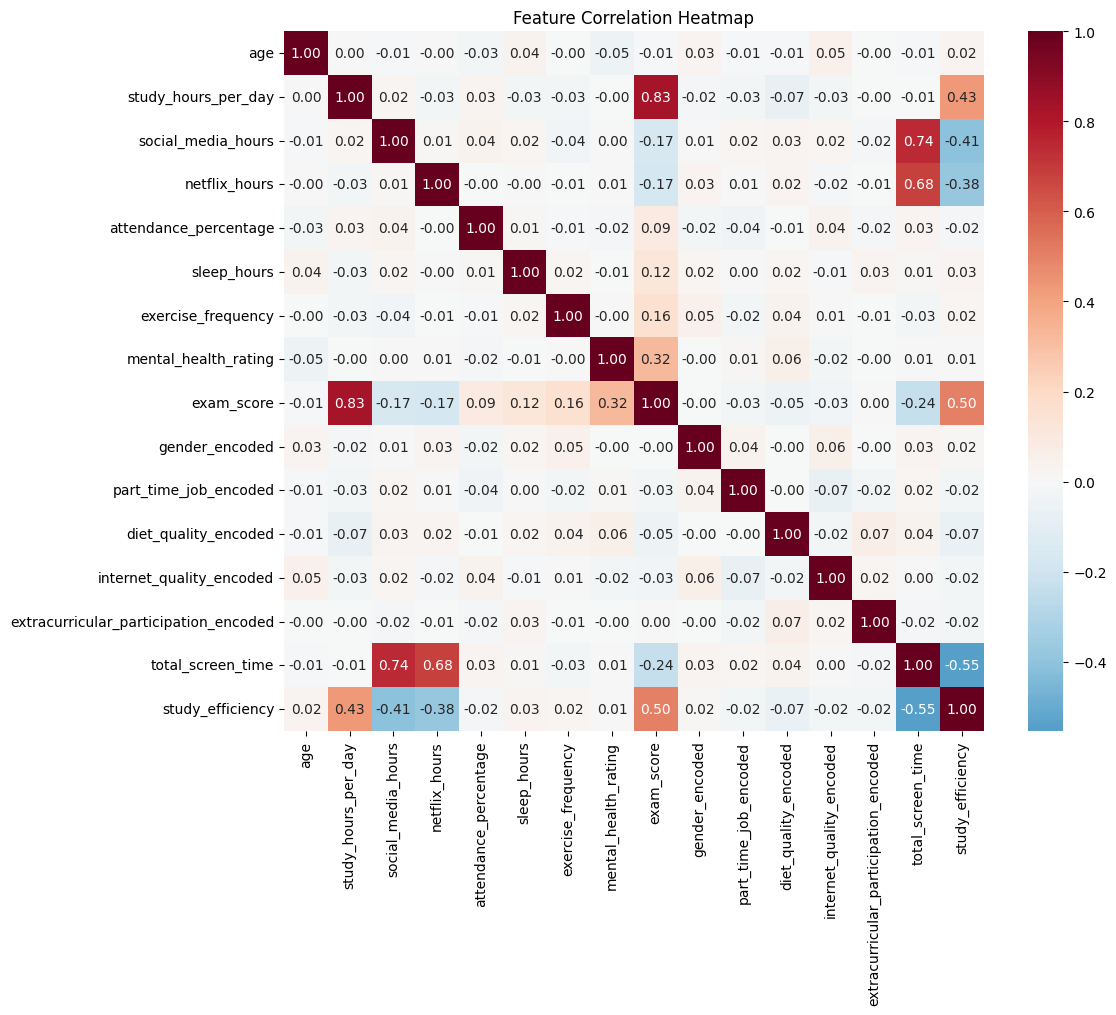

In [101]:
# Correlation analysis
numeric_df = data_processed.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, square=True, fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [102]:
# Key correlations with exam score
exam_correlations = correlation_matrix['exam_score'].drop('exam_score').sort_values(key=abs, ascending=False)
print("\nTop correlations with exam score:")
for feature, corr in exam_correlations.head(5).items():
    print(f"  {feature}: {corr:.3f}")


Top correlations with exam score:
  study_hours_per_day: 0.825
  study_efficiency: 0.501
  mental_health_rating: 0.322
  total_screen_time: -0.238
  netflix_hours: -0.172


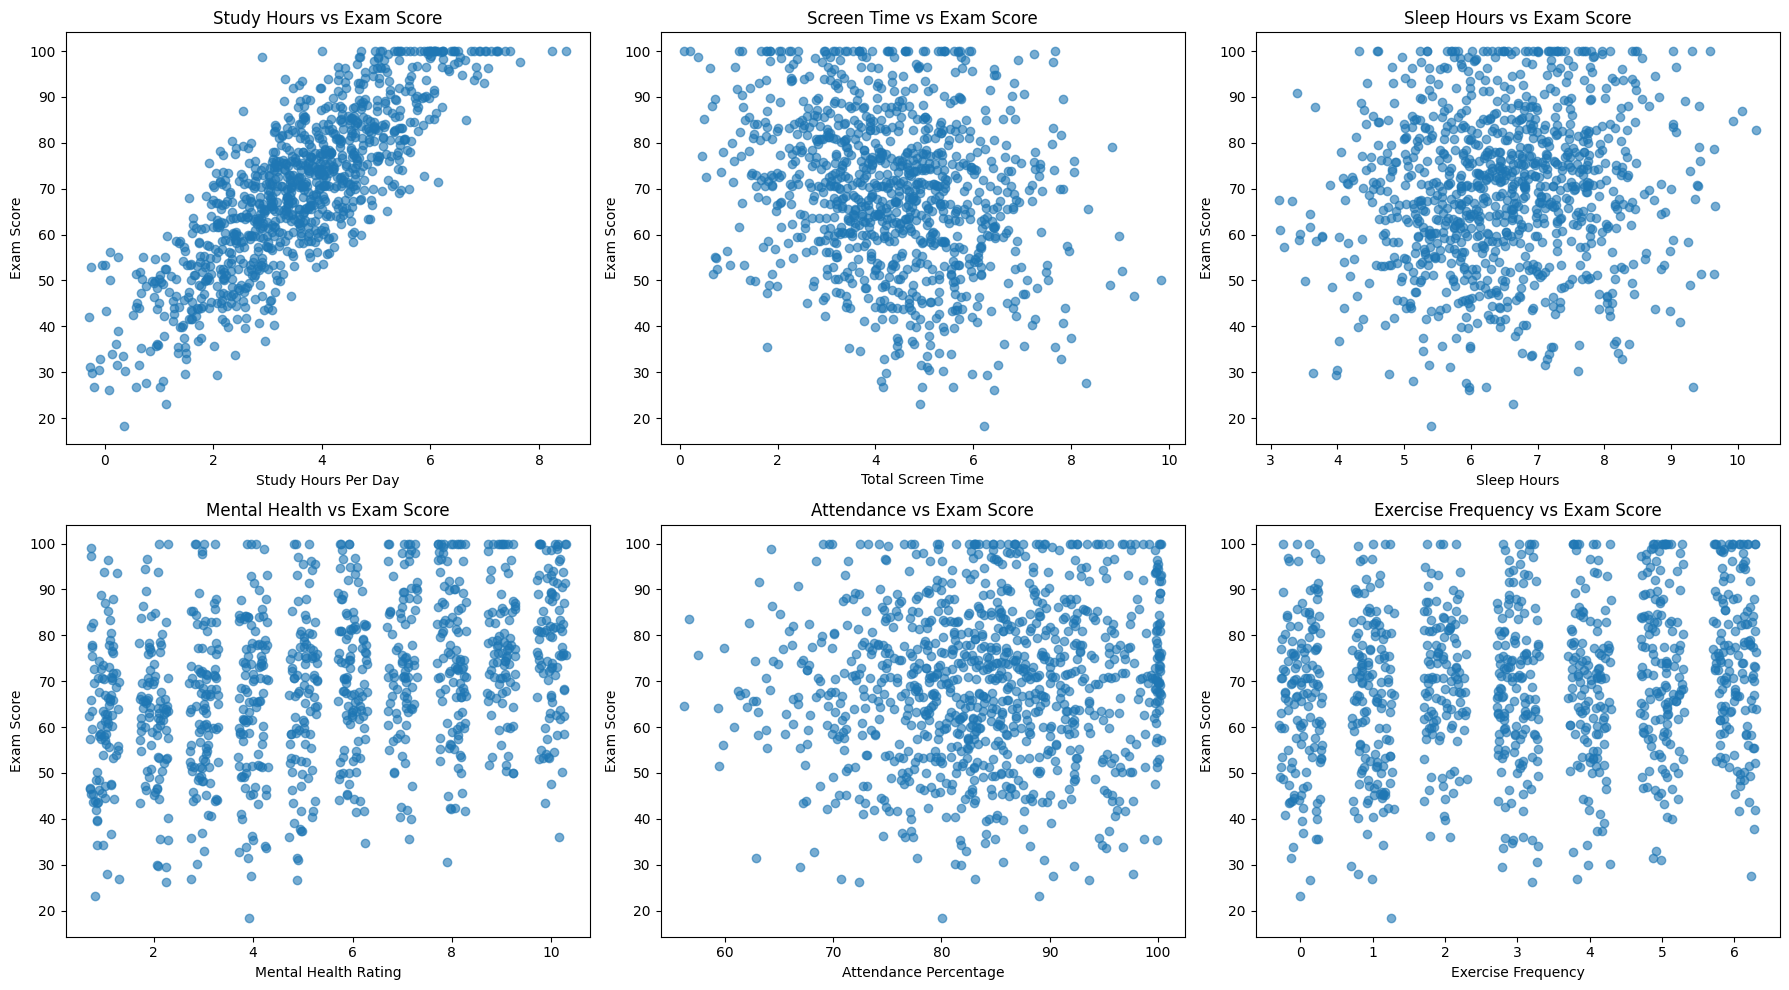

In [103]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # Flatten to simplify indexing

# Plot each relationship
relationships = [
    ('study_hours_per_day', 'Study Hours vs Exam Score'),
    ('total_screen_time', 'Screen Time vs Exam Score'),
    ('sleep_hours', 'Sleep Hours vs Exam Score'),
    ('mental_health_rating', 'Mental Health vs Exam Score'),
    ('attendance_percentage', 'Attendance vs Exam Score'),
    ('exercise_frequency', 'Exercise Frequency vs Exam Score')
]

for i, (feature, title) in enumerate(relationships):
    x = data_processed[feature] + np.random.uniform(-0.3, 0.3, size=len(data_processed))
    y = data_processed['exam_score']
    axes[i].scatter(x, y, alpha=0.6)
    axes[i].set_xlabel(feature.replace('_', ' ').title())
    axes[i].set_ylabel('Exam Score')
    axes[i].set_title(title)

plt.tight_layout()
plt.show()


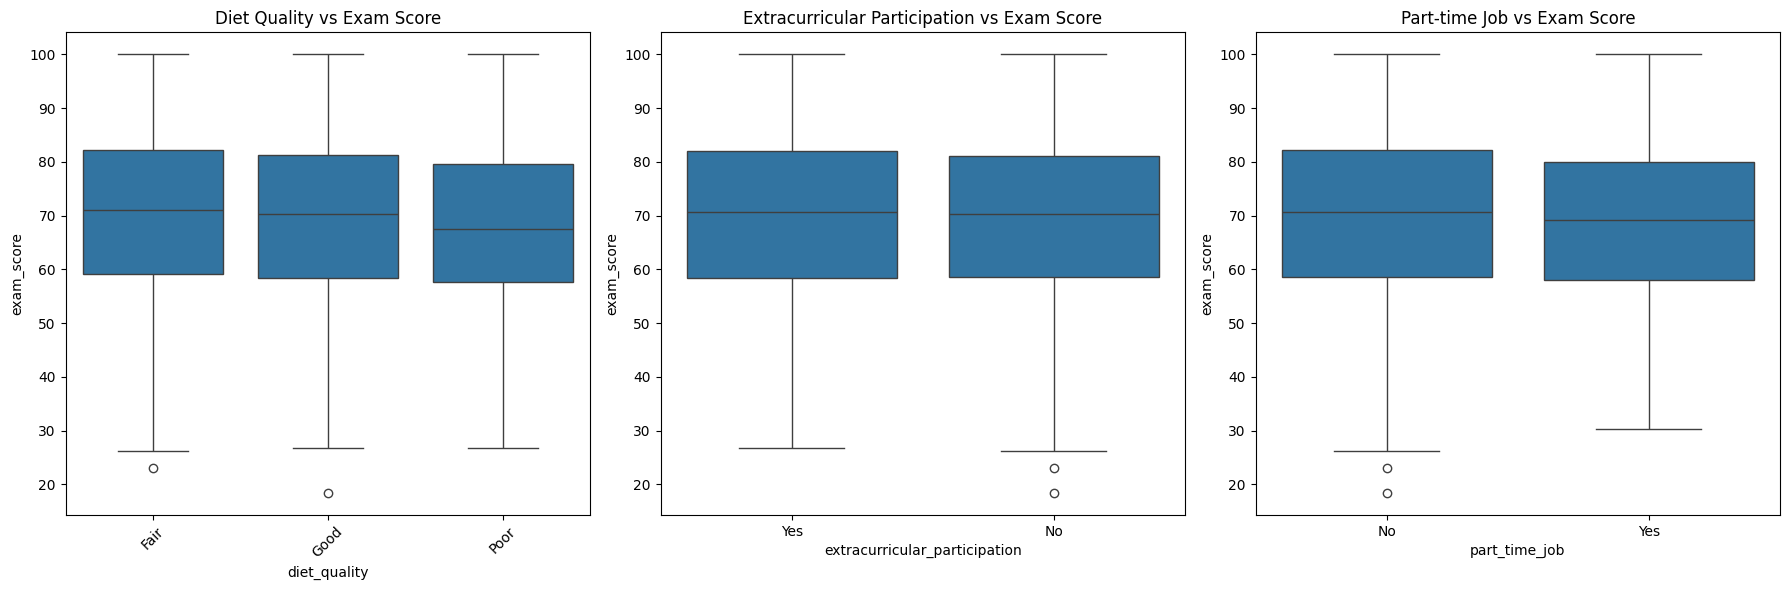

In [104]:
# Categorical analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(data=data_processed, x='diet_quality', y='exam_score', ax=axes[0])
axes[0].set_title('Diet Quality vs Exam Score')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(data=data_processed, x='extracurricular_participation', y='exam_score', ax=axes[1])
axes[1].set_title('Extracurricular Participation vs Exam Score')

sns.boxplot(data=data_processed, x='part_time_job', y='exam_score', ax=axes[2])
axes[2].set_title('Part-time Job vs Exam Score')

plt.tight_layout()
plt.show()

# **4 Clustering Analysis**

In [105]:
# Prepare clustering features (exclude exam_score and student_id)
clustering_features = [
    'age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
    'attendance_percentage', 'sleep_hours', 'exercise_frequency',
    'mental_health_rating', 'total_screen_time', 'study_efficiency'
] + [col + '_encoded' for col in categorical_cols]


X_cluster = data_processed[clustering_features]
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

In [106]:
# Find optimal number of clusters
k_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster_scaled, kmeans.labels_))

In [107]:
# Elbow method (1st derivative of inertia curve)
inertia_deltas = np.diff(inertias)
elbow_k_index = np.argmax(np.abs(inertia_deltas))
elbow_k = k_range[elbow_k_index]

# Silhouette method (maximum score)
silhouette_k_index = np.argmax(silhouette_scores)
silhouette_k = k_range[silhouette_k_index]

# Clusters results 
print("\nK\tInertia\t\tΔInertia\tSilhouette")
print("-" * 50)
for i in range(len(k_range)):
    k = k_range[i]
    inertia = inertias[i]
    delta = abs(inertia_deltas[i]) if i < len(inertia_deltas) else "—"
    silh = silhouette_scores[i]
    print(f"{k}\t{inertia:.2f}\t{delta if isinstance(delta,str) else f'{delta:.2f}'}\t\t{silh:.4f}")



K	Inertia		ΔInertia	Silhouette
--------------------------------------------------
2	13528.50	725.50		0.0926
3	12803.00	596.23		0.0881
4	12206.76	408.03		0.0807
5	11798.74	339.88		0.0646
6	11458.86	228.27		0.0606
7	11230.59	265.73		0.0591
8	10964.86	212.86		0.0655
9	10752.00	196.69		0.0579
10	10555.31	—		0.0636


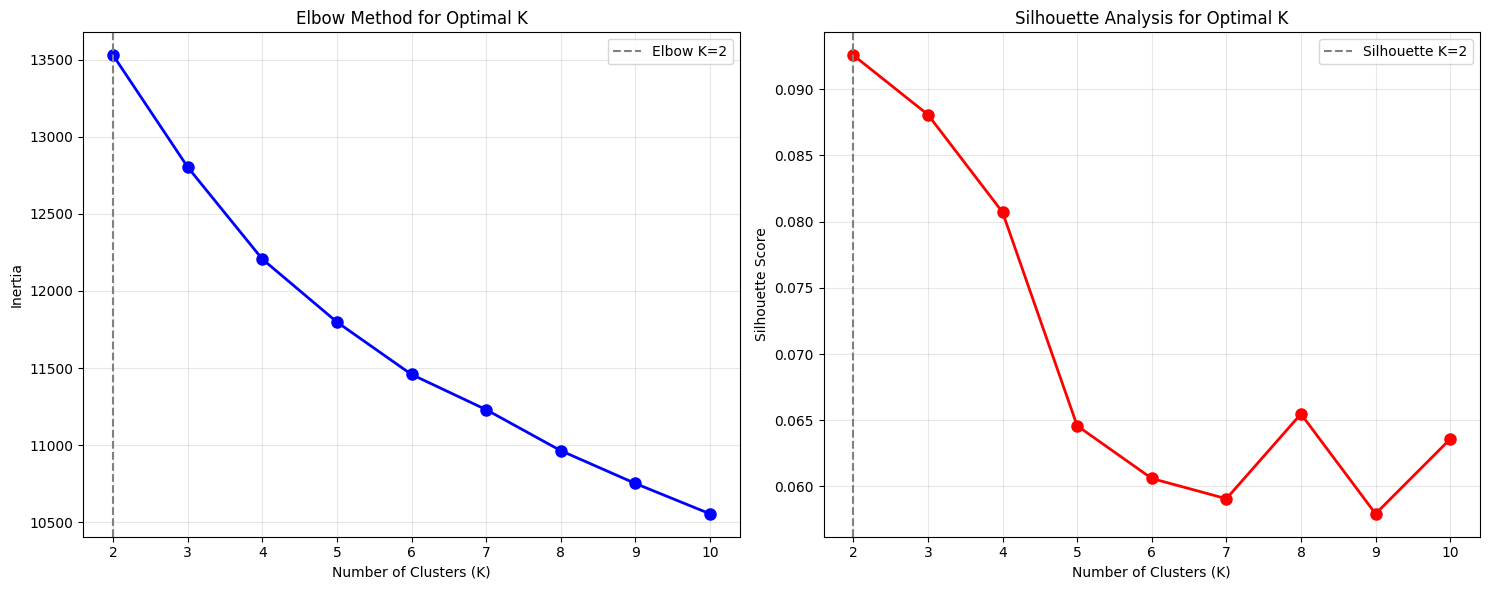

In [108]:
# Plot optimization metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Elbow Method
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal K')
ax1.grid(True, alpha=0.3)
ax1.axvline(elbow_k, color='gray', linestyle='--', label=f'Elbow K={elbow_k}')
ax1.legend()

# Silhouette Score
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis for Optimal K')
ax2.grid(True, alpha=0.3)
ax2.axvline(silhouette_k, color='gray', linestyle='--', label=f'Silhouette K={silhouette_k}')
ax2.legend()

plt.tight_layout()
plt.show()

In [109]:
# Apply optimal clustering
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal K (Elbow Method): {elbow_k} (ΔInertia = {abs(inertia_deltas[elbow_k_index]):.2f})")
print(f"Optimal K: {optimal_k} (Silhouette Score: {max(silhouette_scores):.3f})")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
data_processed['cluster'] = kmeans_final.fit_predict(X_cluster_scaled)

# Analyze clusters
print(f"\nCluster Analysis:")
cluster_summary = data_processed.groupby('cluster').agg({
    'exam_score': ['mean', 'count'],
    'study_hours_per_day': 'mean',
    'total_screen_time': 'mean',
    'sleep_hours': 'mean',
    'mental_health_rating': 'mean',
    'attendance_percentage': 'mean'
}).round(2)

print(cluster_summary)

Optimal K (Elbow Method): 2 (ΔInertia = 725.50)
Optimal K: 2 (Silhouette Score: 0.093)

Cluster Analysis:
        exam_score       study_hours_per_day total_screen_time sleep_hours  \
              mean count                mean              mean        mean   
cluster                                                                      
0            65.61   596                3.41              5.35        6.47   
1            75.49   404                3.76              2.81        6.48   

        mental_health_rating attendance_percentage  
                        mean                  mean  
cluster                                             
0                       5.47                 84.19  
1                       5.39                 84.05  


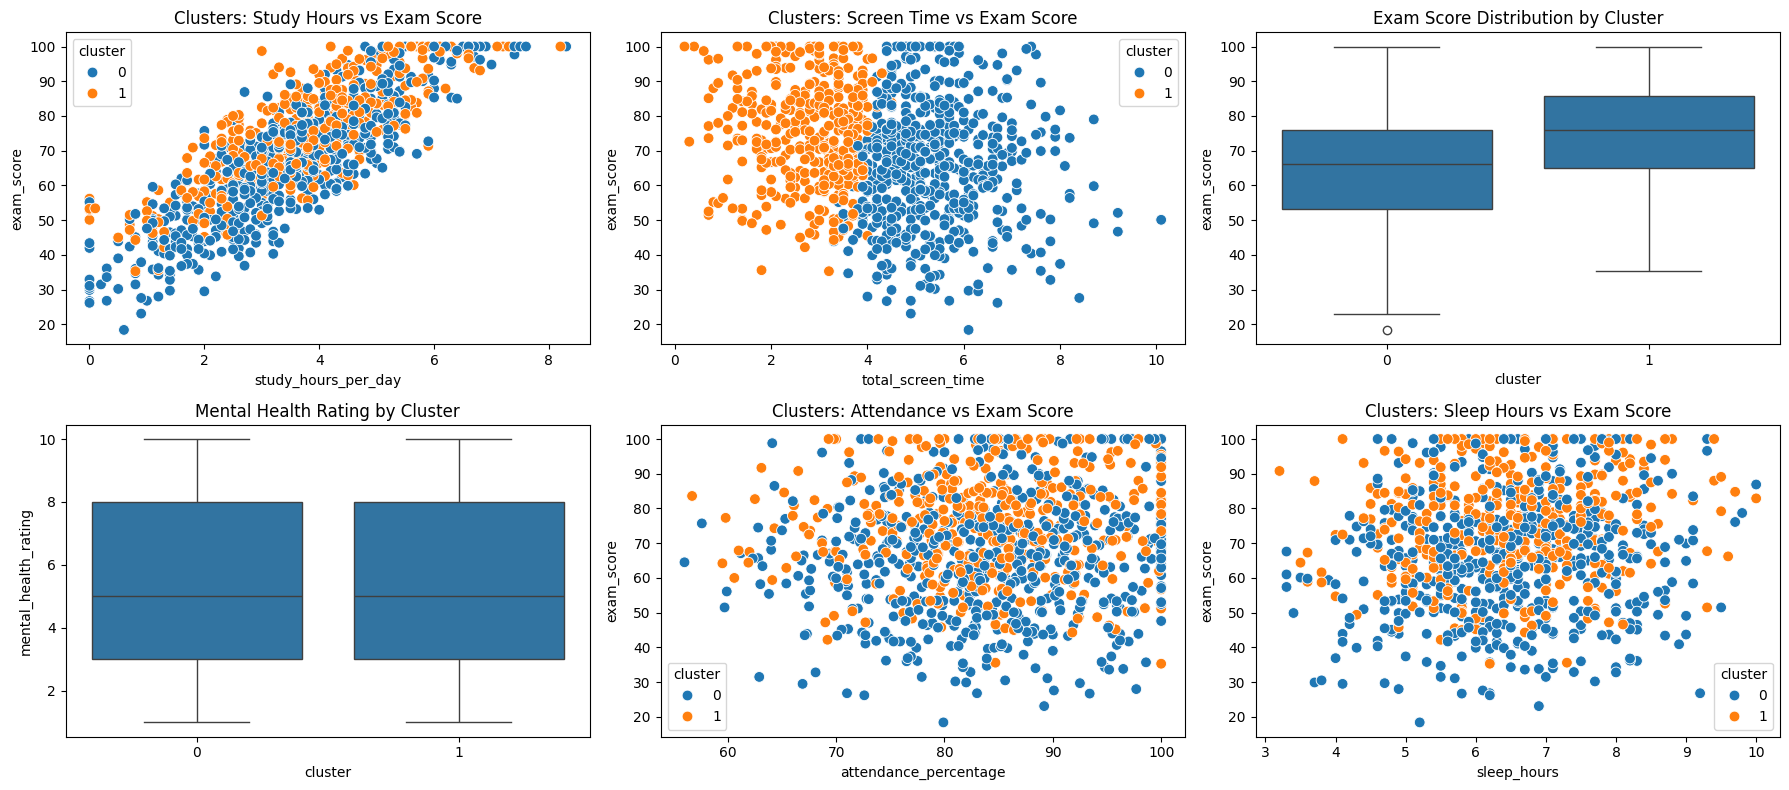

In [110]:
plt.figure(figsize=(18, 8))

# Study Hours vs Exam Score
plt.subplot(2, 3, 1)
sns.scatterplot(data=data_processed, x='study_hours_per_day', y='exam_score', hue='cluster', s=60)
plt.title('Clusters: Study Hours vs Exam Score')

# Screen Time vs Exam Score
plt.subplot(2, 3, 2)
sns.scatterplot(data=data_processed, x='total_screen_time', y='exam_score', hue='cluster', s=60)
plt.title('Clusters: Screen Time vs Exam Score')

# Exam Score Distribution by Cluster
plt.subplot(2, 3, 3)
sns.boxplot(data=data_processed, x='cluster', y='exam_score')
plt.title('Exam Score Distribution by Cluster')

# Mental Health Rating by Cluster (boxplot)
plt.subplot(2, 3, 4)
sns.boxplot(data=data_processed, x='cluster', y='mental_health_rating')
plt.title('Mental Health Rating by Cluster')

# Attendance vs Exam Score
plt.subplot(2, 3, 5)
sns.scatterplot(data=data_processed, x='attendance_percentage', y='exam_score', hue='cluster', s=60)
plt.title('Clusters: Attendance vs Exam Score')

# Sleep Hours vs Exam Score
plt.subplot(2, 3, 6)
sns.scatterplot(data=data_processed, x='sleep_hours', y='exam_score', hue='cluster', s=60)
plt.title('Clusters: Sleep Hours vs Exam Score')

plt.tight_layout()
plt.show()


# **5 Regression Analysis**

In [111]:
# Prepare regression data
X_regression = data_processed[clustering_features]
y_regression = data_processed['exam_score']

In [112]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_regression, y_regression, 
                                                    test_size=0.2, random_state=42)

In [113]:
# Scale features
scaler_regression = StandardScaler()
X_train_scaled = scaler_regression.fit_transform(X_train)
X_test_scaled = scaler_regression.transform(X_test)

In [114]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
}

In [115]:
# Model evaluation
results = {}
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae, 'RMSE': rmse, 'R²': r2,
        'CV_R²_Mean': cv_scores.mean(), 'CV_R²_Std': cv_scores.std(),
        'Predictions': y_pred
    }
# Results summary
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[m]['MAE'] for m in results.keys()],
    'RMSE': [results[m]['RMSE'] for m in results.keys()],
    'R²': [results[m]['R²'] for m in results.keys()],
    'CV_R²_Mean': [results[m]['CV_R²_Mean'] for m in results.keys()]
}).round(3)

print("Model Performance Comparison:")
print(results_df.to_string(index=False))

best_model = results_df.loc[results_df['R²'].idxmax(), 'Model']
print(f"\nBest Model: {best_model}")

Model Performance Comparison:
            Model   MAE  RMSE    R²  CV_R²_Mean
Linear Regression 4.161 5.128 0.897       0.896
    Decision Tree 7.394 9.532 0.646       0.678
    Random Forest 5.024 6.229 0.849       0.857

Best Model: Linear Regression


In [116]:
# Feature importance (for tree-based models)
print(f"\nFeature Importance (Random Forest):")
rf_model = models['Random Forest']
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(importance_df.head(10).to_string(index=False))



Feature Importance (Random Forest):
              Feature  Importance
  study_hours_per_day    0.538109
     study_efficiency    0.233528
 mental_health_rating    0.100855
          sleep_hours    0.031846
   exercise_frequency    0.022758
attendance_percentage    0.017291
        netflix_hours    0.012343
    total_screen_time    0.012152
   social_media_hours    0.011132
                  age    0.007190


# **6 Classification Task**

In [117]:
# Convert scores into performance levels
score_33 = data_processed['exam_score'].quantile(0.33)
score_67 = data_processed['exam_score'].quantile(0.67)

def categorize_performance(score):
    if score <= score_33:
        return 'Low'
    elif score <= score_67:
        return 'Average'
    else:
        return 'High'

data_processed['performance_level'] = data_processed['exam_score'].apply(categorize_performance)

print(f"Performance Level Distribution:")
print(data_processed['performance_level'].value_counts())
print(f"\nThresholds: Low ≤ {score_33:.1f}, Average ≤ {score_67:.1f}, High > {score_67:.1f}")

Performance Level Distribution:
performance_level
Average    338
Low        332
High       330
Name: count, dtype: int64

Thresholds: Low ≤ 62.7, Average ≤ 77.0, High > 77.0


In [118]:
# Prepare classification data
X_classification = data_processed[clustering_features]
y_classification = data_processed['performance_level']

# Encode target variable
le_target = LabelEncoder()
y_classification_encoded = le_target.fit_transform(y_classification)

# Train-test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_classification, y_classification_encoded, test_size=0.2, random_state=42, stratify=y_classification_encoded
)

# Scale features
scaler_classification = StandardScaler()
X_train_clf_scaled = scaler_classification.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_classification.transform(X_test_clf)

In [119]:
# Classification models
clf_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
}

In [120]:
# Classification model evaluation
clf_results = {}
for name, model in clf_models.items():
    # Use scaled data for Logistic Regression, original for tree-based models
    if name == 'Logistic Regression':
        X_train_model = X_train_clf_scaled
        X_test_model = X_test_clf_scaled
    else:
        X_train_model = X_train_clf
        X_test_model = X_test_clf
    
    # Train model
    model.fit(X_train_model, y_train_clf)
    y_pred_clf = model.predict(X_test_model)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_model, y_train_clf, cv=5, scoring='accuracy')
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_clf, y_pred_clf)
    f1 = f1_score(y_test_clf, y_pred_clf, average='weighted')
    
    clf_results[name] = {
        'Accuracy': accuracy,
        'F1_Score': f1,
        'CV_Accuracy_Mean': cv_scores.mean(),
        'CV_Accuracy_Std': cv_scores.std(),
        'Predictions': y_pred_clf,
        'Model': model
    }


In [121]:
for name, result in clf_results.items():
    print(f"\n{name}:")
    print(f"  Accuracy: {result['Accuracy']:.3f}")
    print(f"  F1-Score: {result['F1_Score']:.3f}")
    print(f"  CV Accuracy: {result['CV_Accuracy_Mean']:.3f} (±{result['CV_Accuracy_Std']:.3f})")



Logistic Regression:
  Accuracy: 0.785
  F1-Score: 0.785
  CV Accuracy: 0.805 (±0.012)

Decision Tree:
  Accuracy: 0.685
  F1-Score: 0.691
  CV Accuracy: 0.705 (±0.035)

Random Forest:
  Accuracy: 0.750
  F1-Score: 0.752
  CV Accuracy: 0.775 (±0.047)


---

In [122]:
# Classification results summary
clf_results_df = pd.DataFrame({
    'Model': list(clf_results.keys()),
    'Accuracy': [clf_results[m]['Accuracy'] for m in clf_results.keys()],
    'F1_Score': [clf_results[m]['F1_Score'] for m in clf_results.keys()],
    'CV_Accuracy_Mean': [clf_results[m]['CV_Accuracy_Mean'] for m in clf_results.keys()]
}).round(3)

print("Classification Model Performance Comparison:")
print(clf_results_df.to_string(index=False))

best_clf_model = clf_results_df.loc[clf_results_df['Accuracy'].idxmax(), 'Model']
print(f"\nBest Classification Model: {best_clf_model}")

Classification Model Performance Comparison:
              Model  Accuracy  F1_Score  CV_Accuracy_Mean
Logistic Regression     0.785     0.785             0.805
      Decision Tree     0.685     0.691             0.705
      Random Forest     0.750     0.752             0.775

Best Classification Model: Logistic Regression


---

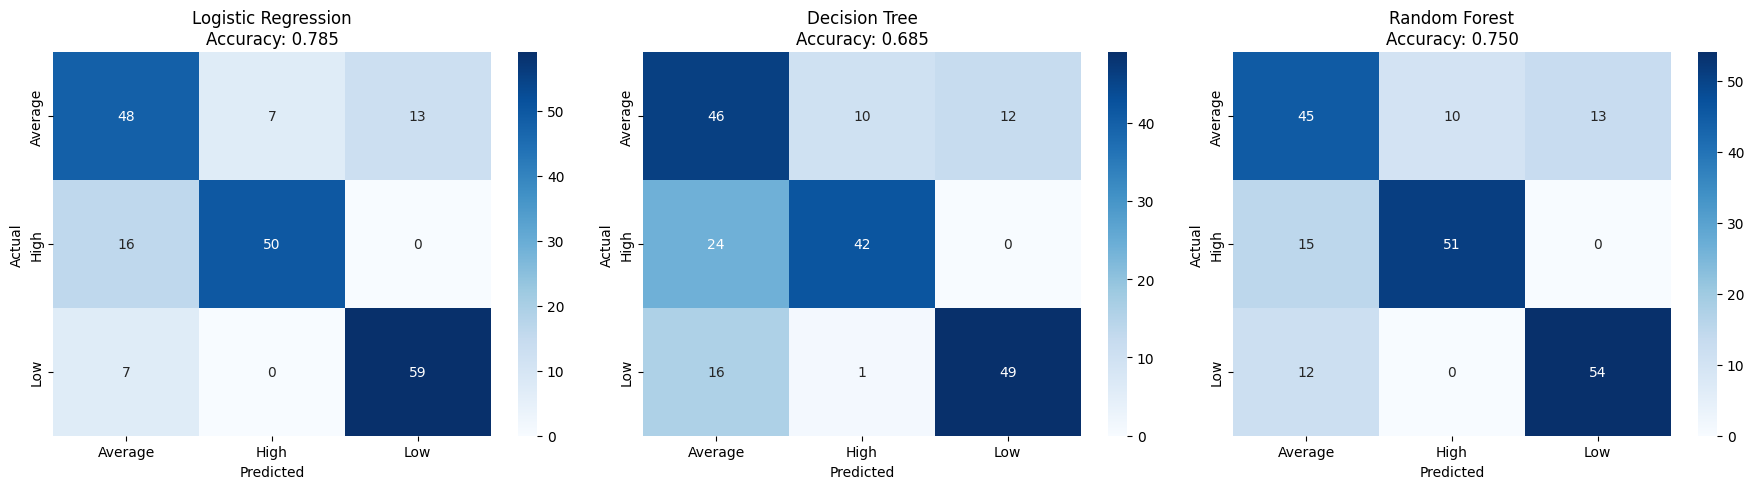

In [123]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
class_names = le_target.classes_

for i, (name, result) in enumerate(clf_results.items()):
    cm = confusion_matrix(y_test_clf, result['Predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=axes[i])
    axes[i].set_title(f'{name}\nAccuracy: {result["Accuracy"]:.3f}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()


In [124]:
# Classification report for best performing model
best_clf_model = max(clf_results.keys(), key=lambda x: clf_results[x]['Accuracy'])
best_clf_result = clf_results[best_clf_model]
print(f"\nDetailed Classification Report - Best Model ({best_clf_model}):")
print("="*60)
print(classification_report(y_test_clf, best_clf_result['Predictions'], 
                          target_names=class_names))


Detailed Classification Report - Best Model (Logistic Regression):
              precision    recall  f1-score   support

     Average       0.68      0.71      0.69        68
        High       0.88      0.76      0.81        66
         Low       0.82      0.89      0.86        66

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200



---

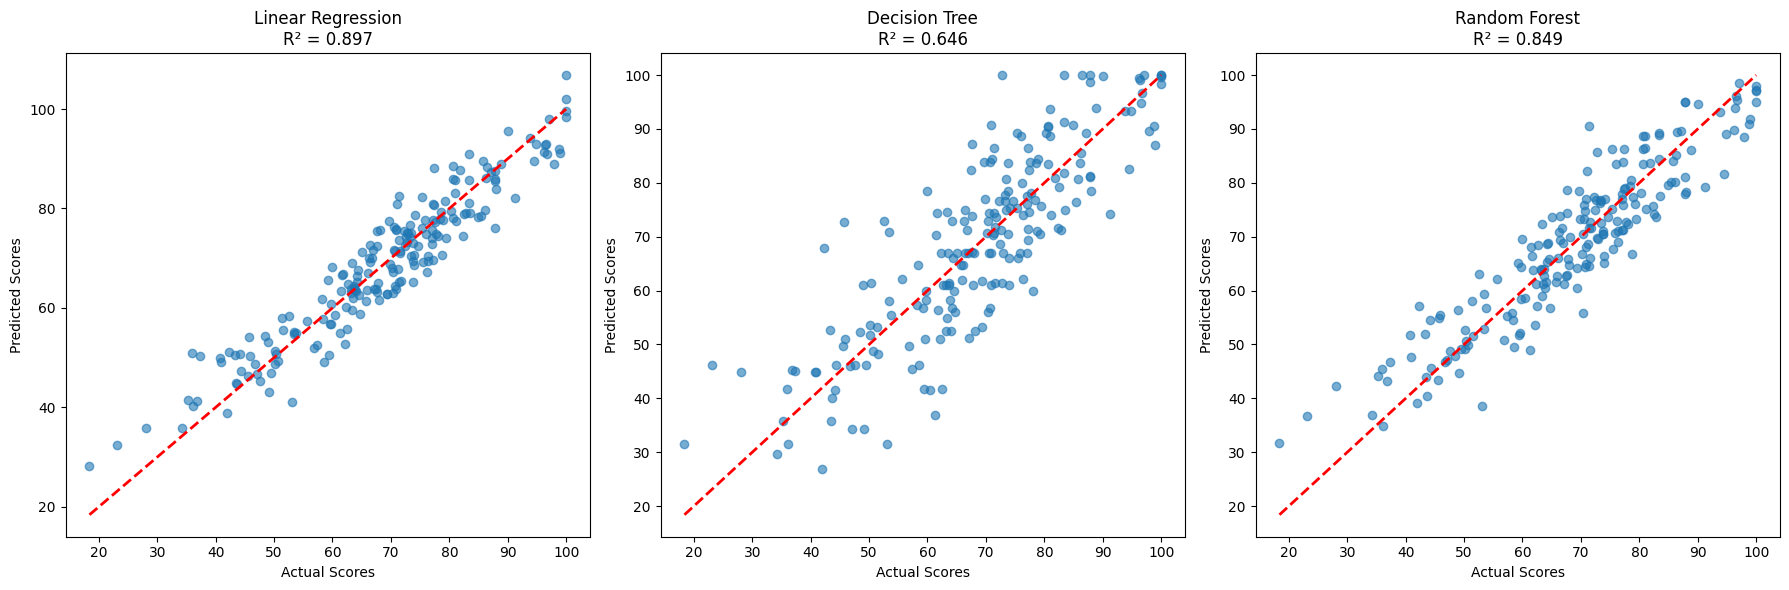

In [125]:
# Visualization of predictions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (name, result) in enumerate(results.items()):
    axes[i].scatter(y_test, result['Predictions'], alpha=0.6)
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[i].set_xlabel('Actual Scores')
    axes[i].set_ylabel('Predicted Scores')
    axes[i].set_title(f'{name}\nR² = {result["R²"]:.3f}')

plt.tight_layout()
plt.show()


 # **7 Results and Analysis**I

In [126]:
# 1. Regression Results
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[m]['MAE'] for m in results.keys()],
    'RMSE': [results[m]['RMSE'] for m in results.keys()],
    'R²': [results[m]['R²'] for m in results.keys()],
    'CV_R²_Mean': [results[m]['CV_R²_Mean'] for m in results.keys()]
}).round(3)
print("="*40)
print(results_df.to_string(index=False))
best_reg_model = results_df.loc[results_df['R²'].idxmax(), 'Model']
print(f"\nBest Regression Model: {best_reg_model} (R² = {results_df.loc[results_df['R²'].idxmax(), 'R²']:.3f})")


            Model   MAE  RMSE    R²  CV_R²_Mean
Linear Regression 4.161 5.128 0.897       0.896
    Decision Tree 7.394 9.532 0.646       0.678
    Random Forest 5.024 6.229 0.849       0.857

Best Regression Model: Linear Regression (R² = 0.897)


In [127]:
# Feature importance for Random Forest
if 'Random Forest' in models:
    print(f"\nTop 10 Feature Importance (Random Forest Regressor):")
    rf_model = models['Random Forest']
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    for i, (feature, importance) in enumerate(importance_df.head(10).values):
        print(f"  {i+1:2d}. {feature:25s}: {importance:.3f}")


Top 10 Feature Importance (Random Forest Regressor):
   1. study_hours_per_day      : 0.538
   2. study_efficiency         : 0.234
   3. mental_health_rating     : 0.101
   4. sleep_hours              : 0.032
   5. exercise_frequency       : 0.023
   6. attendance_percentage    : 0.017
   7. netflix_hours            : 0.012
   8. total_screen_time        : 0.012
   9. social_media_hours       : 0.011
  10. age                      : 0.007


In [128]:
# 2. Classification Results
clf_results_df = pd.DataFrame({
    'Model': list(clf_results.keys()),
    'Accuracy': [clf_results[m]['Accuracy'] for m in clf_results.keys()],
    'F1_Score': [clf_results[m]['F1_Score'] for m in clf_results.keys()],
    'CV_Accuracy_Mean': [clf_results[m]['CV_Accuracy_Mean'] for m in clf_results.keys()]
}).round(3)

print(clf_results_df.to_string(index=False))
best_clf_model = clf_results_df.loc[clf_results_df['Accuracy'].idxmax(), 'Model']
print(f"\nBest Classification Model: {best_clf_model} (Accuracy = {clf_results_df.loc[clf_results_df['Accuracy'].idxmax(), 'Accuracy']:.3f})")


              Model  Accuracy  F1_Score  CV_Accuracy_Mean
Logistic Regression     0.785     0.785             0.805
      Decision Tree     0.685     0.691             0.705
      Random Forest     0.750     0.752             0.775

Best Classification Model: Logistic Regression (Accuracy = 0.785)


In [129]:
# 3. Clustering Results
print(f"Optimal number of clusters: {optimal_k}")
print(f"Silhouette Score: {max(silhouette_scores):.3f}")
print(f"\nCluster Summary:")
cluster_summary = data_processed.groupby('cluster').agg({
    'exam_score': ['mean', 'count'],
    'study_hours_per_day': 'mean',
    'total_screen_time': 'mean',
    'sleep_hours': 'mean',
    'mental_health_rating': 'mean',
    'attendance_percentage': 'mean'
}).round(2)
print(cluster_summary)

Optimal number of clusters: 2
Silhouette Score: 0.093

Cluster Summary:
        exam_score       study_hours_per_day total_screen_time sleep_hours  \
              mean count                mean              mean        mean   
cluster                                                                      
0            65.61   596                3.41              5.35        6.47   
1            75.49   404                3.76              2.81        6.48   

        mental_health_rating attendance_percentage  
                        mean                  mean  
cluster                                             
0                       5.47                 84.19  
1                       5.39                 84.05  


In [130]:
# Define efficient students (high performance with low study hours)
low_study_threshold = data_processed['study_hours_per_day'].quantile(0.33)
high_score_threshold = data_processed['exam_score'].quantile(0.67)

efficient_students = data_processed[
    (data_processed['study_hours_per_day'] <= low_study_threshold) & 
    (data_processed['exam_score'] >= high_score_threshold)]

print(f"  • Low study time: ≤{low_study_threshold:.1f} hours/day (bottom 33%)")
print(f"  • High exam scores: ≥{high_score_threshold:.1f} points (top 33%)")
print(f"  • Students identified: {len(efficient_students)} ({len(efficient_students)/len(data_processed)*100:.1f}% of total)")    

  • Low study time: ≤2.9 hours/day (bottom 33%)
  • High exam scores: ≥77.0 points (top 33%)
  • Students identified: 9 (0.9% of total)


In [131]:
# Characteristics of efficient students vs others
SAMPLE_SIZE = 9  # Sample size for statistical analysis

print(f"Efficient students found: {len(efficient_students)}")

if len(efficient_students) >= SAMPLE_SIZE:
    other_students = data_processed[~data_processed.index.isin(efficient_students.index)]
    
    print(f"\nCharacteristics comparison (Efficient vs Others):")
    characteristics = ['sleep_hours', 'mental_health_rating', 'attendance_percentage', 
                      'exercise_frequency', 'total_screen_time']
    
    comparison = pd.DataFrame({
        'Efficient_Students': efficient_students[characteristics].mean(),
        'Other_Students': other_students[characteristics].mean()
    }).round(2)
    comparison['Difference'] = (comparison['Efficient_Students'] - comparison['Other_Students']).round(2)
    comparison['Percent_Diff'] = ((comparison['Efficient_Students'] / comparison['Other_Students'] - 1) * 100).round(1)
    
    print(comparison)

Efficient students found: 9

Characteristics comparison (Efficient vs Others):
                       Efficient_Students  Other_Students  Difference  \
sleep_hours                          7.82            6.46        1.36   
mental_health_rating                 7.78            5.42        2.36   
attendance_percentage               86.31           84.11        2.20   
exercise_frequency                   4.22            3.03        1.19   
total_screen_time                    2.69            4.34       -1.65   

                       Percent_Diff  
sleep_hours                    21.1  
mental_health_rating           43.5  
attendance_percentage           2.6  
exercise_frequency             39.3  
total_screen_time             -38.0  


In [132]:
# Categorical characteristics analysis\

if len(efficient_students) >= SAMPLE_SIZE:
    print(f"\nLifestyle Patterns in Efficient Students:")
    
    # Diet quality
    efficient_good_diet = efficient_students['diet_quality'].isin(['Good', 'Excellent']).mean() * 100
    others_good_diet = data_processed[~data_processed.index.isin(efficient_students.index)]['diet_quality'].isin(['Good', 'Excellent']).mean() * 100
    
    # Extracurricular participation
    efficient_extracur = (efficient_students['extracurricular_participation'] == 'Yes').mean() * 100
    others_extracur = (data_processed[~data_processed.index.isin(efficient_students.index)]['extracurricular_participation'] == 'Yes').mean() * 100
    
    # Part-time job
    efficient_job = (efficient_students['part_time_job'] == 'Yes').mean() * 100
    others_job = (data_processed[~data_processed.index.isin(efficient_students.index)]['part_time_job'] == 'Yes').mean() * 100
    
    print(f"  • Good/Excellent Diet Quality: {efficient_good_diet:.1f}% vs {others_good_diet:.1f}% (others)")
    print(f"  • Extracurricular Participation: {efficient_extracur:.1f}% vs {others_extracur:.1f}% (others)")
    print(f"  • Have Part-time Job: {efficient_job:.1f}% vs {others_job:.1f}% (others)")


Lifestyle Patterns in Efficient Students:
  • Good/Excellent Diet Quality: 33.3% vs 37.8% (others)
  • Extracurricular Participation: 33.3% vs 31.8% (others)
  • Have Part-time Job: 44.4% vs 21.3% (others)


In [133]:
 # Key insights
print(f"\nKey Insights:")
top_differences = comparison['Difference'].abs().sort_values(ascending=False)
for i, feature in enumerate(top_differences.head(3).index):
    diff = comparison.loc[feature, 'Difference']
    direction = "higher" if diff > 0 else "lower"
    print(f"  {i+1}. Efficient students have {direction} {feature.replace('_', ' ')}: {abs(diff):.2f} difference")


Key Insights:
  1. Efficient students have higher mental health rating: 2.36 difference
  2. Efficient students have higher attendance percentage: 2.20 difference
  3. Efficient students have lower total screen time: 1.65 difference


In [134]:
# Obejctive 1
print(f"  → Found {optimal_k} clusters with clear lifestyle patterns")

# Objective 2
print(f"  → Best regression model R² = {results_df.loc[results_df['R²'].idxmax(), 'R²']:.3f}")
print(f"  → Best classification accuracy = {clf_results_df.loc[clf_results_df['Accuracy'].idxmax(), 'Accuracy']:.3f}")

# Objective 3
if len(efficient_students) > 5:
    print(f"  → Identified {len(efficient_students)} efficient students with distinct traits")
else:
    print(f"  → Limited sample size ({len(efficient_students)}) for robust analysis")


  → Found 2 clusters with clear lifestyle patterns
  → Best regression model R² = 0.897
  → Best classification accuracy = 0.785
  → Identified 9 efficient students with distinct traits


## **8 Key Findings Summary** 

In [135]:
print("\n[1] PROBLEM DEFINITION")
print(f"• Students analyzed: {len(data_processed)}")
print(f"• Efficient students: {len(efficient_students)}")
print(f"• Clusters found: {optimal_k}")

print("\n[2] DATA PREPROCESSING")
print(f"• Completeness: {(1 - data_processed.isnull().sum().sum() / (data_processed.shape[0] * data_processed.shape[1])) * 100:.1f}%")
print(f"• Categorical features encoded: {len(categorical_cols)}")
print("• Engineered features: 2")

print("\n[3] CLUSTERING")
print(f"• Optimal K: {optimal_k}")
print(f"• Silhouette score: {max(silhouette_scores):.3f}")

print("\n[4] REGRESSION")
print(f"• Best model: {best_model}")
print(f"• Best R²: {results_df.loc[results_df['R²'].idxmax(), 'R²']:.3f}")

print("\n[5] CLASSIFICATION")
print(f"• Best model: {best_clf_model}")
print(f"• Best accuracy: {clf_results_df.loc[clf_results_df['Accuracy'].idxmax(), 'Accuracy']:.3f}")

if len(efficient_students) > 5:
    print("\n[6] EFFICIENT STUDENT TRAITS")
    top_differences = comparison['Difference'].abs().sort_values(ascending=False)
    for feature in top_differences.head(3).index:
        diff = comparison.loc[feature, 'Difference']
        symbol = "↑" if diff > 0 else "↓"
        print(f"• {symbol} {feature.replace('_', ' ')}: {abs(diff):.2f}")


[1] PROBLEM DEFINITION
• Students analyzed: 1000
• Efficient students: 9
• Clusters found: 2

[2] DATA PREPROCESSING
• Completeness: 99.6%
• Categorical features encoded: 5
• Engineered features: 2

[3] CLUSTERING
• Optimal K: 2
• Silhouette score: 0.093

[4] REGRESSION
• Best model: Linear Regression
• Best R²: 0.897

[5] CLASSIFICATION
• Best model: Logistic Regression
• Best accuracy: 0.785

[6] EFFICIENT STUDENT TRAITS
• ↑ mental health rating: 2.36
• ↑ attendance percentage: 2.20
• ↓ total screen time: 1.65


---

**A. Feature Importance**
- For tree-based models, plot and analyze feature importance

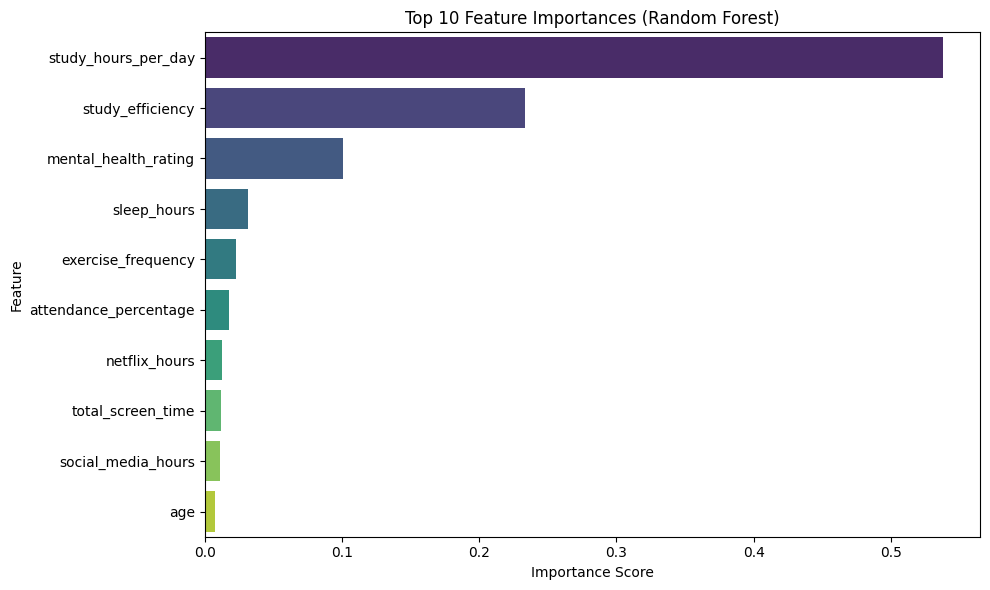

In [136]:
# Plot top 10 feature importances
top_features = importance_df.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

The feature importance results from the Random Forest model reveal that study_hours_per_day is by far the most influential predictor of academic performance, contributing 53.8% to the model’s decision-making. This suggests that, regardless of lifestyle variations, the amount of time a student spends studying each day is the strongest indicator of performance level.

Next is study_efficiency at 23.4%, indicating that how effectively students study is also critical, possibly even outweighing total time spent if used poorly. Mental_health_rating comes third at 10.1%, emphasizing that psychological well-being plays a notable role in student outcomes.

The remaining features, such as sleep hours, exercise frequency, and attendance, have much smaller contributions (under 4%), and screen-related behaviors like Netflix hours and social media use contribute the least (around or below 1.2%). This indicates that while lifestyle factors do matter, academic habits (both time and quality) and mental health are the most decisive in determining performance levels in your dataset.

- For linear models, interpret coefficients 

In [144]:
# Access the trained Linear Regression model
lin_reg_model = models['Linear Regression']

# Create a DataFrame to show feature names and their coefficients
coefficients_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lin_reg_model.coef_
})

# Sort by the actual coefficient values in descending order
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Print the coefficients
print("Linear Regression Coefficients (from most positive to most negative):")
print(coefficients_df.to_string(index=False))

Linear Regression Coefficients (from most positive to most negative):
                              Feature  Coefficient
                  study_hours_per_day     9.519247
                          sleep_hours     1.996515
                 mental_health_rating     1.959363
                   exercise_frequency     1.318119
                part_time_job_encoded     0.346702
                       gender_encoded     0.202614
                attendance_percentage     0.147156
                                  age     0.054452
                     study_efficiency     0.009831
             internet_quality_encoded    -0.059942
extracurricular_participation_encoded    -0.090365
                 diet_quality_encoded    -0.402777
                        netflix_hours    -0.640768
                   social_media_hours    -1.029002
                    total_screen_time    -1.669770


- Identify the top 3–5 features that most affect performance

In [145]:
if len(efficient_students) > 5:
    print("\n[6] EFFICIENT STUDENT TRAITS")
    top_differences = comparison['Difference'].abs().sort_values(ascending=False)
    for feature in top_differences.head(3).index:
        diff = comparison.loc[feature, 'Difference']
        symbol = "↑" if diff > 0 else "↓"
        print(f"• {symbol} {feature.replace('_', ' ')}: {abs(diff):.2f}")


[6] EFFICIENT STUDENT TRAITS
• ↑ mental health rating: 2.36
• ↑ attendance percentage: 2.20
• ↓ total screen time: 1.65


**B. Cluster Profiling**
- Describe common behaviors
    - Cluster 0 has a bit of a screen time. They also have slightly less study hours than Cluster 1. They have the same attendance, sleep, and mental health rating for Cluster 1.
    - Cluster 1 has lesser screen time than Cluster 0. They have slightly more study hours.

- Associate average exam scores with each group
    - Cluster 0 has an average exam score of 65.61
    - Cluster 1 has an average exam score of 75.49

- Comment on trends you observe
    - Lower screen time and higher study hours result to higher exam scores.

**C. Model Performance**

• Which model performed best? Why?

- The best-performing classification model was Logistic Regression, achieving the highest accuracy (78.5%), F1-score (0.785), and cross-validation accuracy mean (80.5%) among all models. Its consistent performance across both training and validation suggests strong generalization to unseen data. The detailed classification report further confirms its reliability, with high precision and recall across all performance levels. In comparison, the Decision Tree and Random Forest models had lower overall metrics and showed less stability. Thus, Logistic Regression was the most effective at predicting student performance levels based on lifestyle features.

• Are there trade-offs between interpretability and accuracy?

- Yes, there are trade-offs between interpretability and accuracy in machine learning models. Simpler models like Logistic Regression and Linear Regression are highly interpretable—they allow you to clearly understand the relationship between input features and predictions. However, they may not capture complex patterns in the data, potentially limiting their accuracy. On the other hand, more complex models like Random Forests often achieve higher accuracy by modeling intricate, non-linear relationships. But this complexity comes at the cost of interpretability, making it harder to explain how predictions are made. In educational or policy contexts where transparency is important, interpretability may be prioritized over slight gains in accuracy.

**D. Real-Life Implications**

• What advice could you give students based on your findings?
- Based on the findings, it could be advised that the students give a little more time on studying hours since it's a huge factor on the scores. The same goes for keeping a good mental health and a attendance record. Students who score well also have less screen time than others.


• Are there surprising or counterintuitive results?
- It's surprising how the diet is not that important considering that nowadays, feeding programs and breakfast programs are popular topics among politics.